# Clustering MNIST

### Michael Frasco 

#### Preliminaries 

In [1]:
sc

In [2]:
import base64
import json
import numpy
from pyspark.mllib.clustering import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
def parse(x):
    digit = json.loads(x)
    array = numpy.fromstring(base64.b64decode(digit["data"]),
                             dtype=numpy.ubyte)
    return (digit["label"], array)

In [4]:
digits = sc.textFile("s3n://stat-37601/digits.base64.json").map(parse)

##### Splitting the Data 

In [5]:
trainData, testData = digits.randomSplit([0.75, 0.25], 6)

##### Methodology 

Here, I will explain how I determine which cluster center is most associated with which label in the training set. First, I use the clusters.predict function to map every picture in the training data to a cluster center. Then I count the number of times each cluster center is associated with each true label. I call this list "mappings". The next step is to see which true label occurs most frequently for each cluster center. With this information, I can create a dictionary that maps cluster center to digit label.

In [6]:
trainPixels = trainData.map(lambda x: x[1])
clusters = KMeans.train(trainPixels, 10, maxIterations=50, runs=10, initializationMode="random")

In [7]:
def getClusterMappings(trainData, clusters):
    trainPreds = trainData.map(lambda x: ((clusters.predict(x[1]), x[0]), 1))
    trainMapped = trainPreds.reduceByKey(lambda x,y: x+y)
    mappings = trainMapped.collect()
    return mappings

In [8]:
def createMappingDic(mappings, k):
    mappingList = []
    for i in range(k):
        iList = []
        for item in mappings:
            if item[0][0] == i:
                iList.append(item)
        mappingList.append(iList)
    mappingDic = {}
    for i in range(k):
        maxValue = 0
        maxLabel = -1
        for item in mappingList[i]:
            if item[1] > maxValue:
                maxValue = item[1]
                maxLabel = item[0][1]
        mappingDic[i] = maxLabel
    return mappingDic

In addition to the method above, I thought of a second method to map each cluster center to a digit label. I would subset the data based on the label and compute the average distance of each subset to each cluster. Then, I map each cluster center to the label subset that is closest to it.

In [9]:
def findNearestLabel(trainData, clusters):
    clusterList = clusters.centers
    clusterDict = {}
    for i in range(len(clusterList)):
        cluster = clusterList[i]
        bestDistance = float("inf")
        bestLabel = -1
        for j in range(10):
            subsetI = trainData.filter(lambda x: x[0] == j)
            distances = subsetI.map(lambda x: np.linalg.norm(x[1] - cluster))
            avgDistance = distances.sum() / distances.count()
            if avgDistance < bestDistance:
                bestLabel = j
                bestDistance = avgDistance
        clusterDict[i] = bestLabel
    return clusterDict

In [10]:
# plotting function
def printClusters(possibleClusters):
    for i in range(len(possibleClusters)):
        image = clusters.centers[possibleClusters[i]]
        image = image.astype(float)/256
        plt.figure(i)
        fig = plt.imshow(image.reshape(28,28))
        fig.set_cmap('gray_r')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

##### Results 

In [ ]:
mappings = getClusterMappings(trainData, clusters)
mappingDic = createMappingDic(mappings, 10)
print mappingDic

In [11]:
# This takes a while, so you might not want to run it.
#mappingsDic2 = findNearestLabel(trainData, clusters)

In [12]:
#print mappingsDic2

{0: 7, 1: 8, 2: 2, 3: 3, 4: 6, 5: 1, 6: 0, 7: 0, 8: 9, 9: 1}


When I run this for the final time, I get that 9/10 of the mappings are the same. The only difference is that the 8th cluster maps to a "9" vs. a "4". This is the most common source of confusion among the digit labels.

Due to the random initializations of the clustering algorithm, when you run this code on your machine you will get different results than me. However, if you look at the printed mapping dictionary in the cell above, you can see which cluster is associated with which label. A key-value pair like (0: 4) means that the 0th element in our clusters.centers list is most often associated with the digit label "4".

You can run the following lines below to see pictures that confirm the values of the mapping dictionary. These are using the results of mappingDic1.

This cluster center is most often assoicated with the label 7


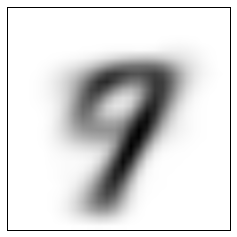

In [14]:
print "This cluster center is most often assoicated with the label " + str(mappingDic[0])
printClusters([0])

This cluster center is most often assoicated with the label 8


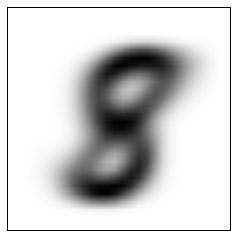

In [15]:
print "This cluster center is most often assoicated with the label " + str(mappingDic[1])
printClusters([1])

This cluster center is most often assoicated with the label 2


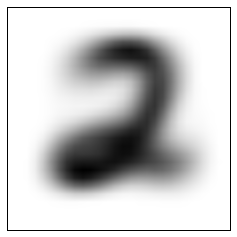

In [16]:
print "This cluster center is most often assoicated with the label " + str(mappingDic[2])
printClusters([2])

This cluster center is most often assoicated with the label 3


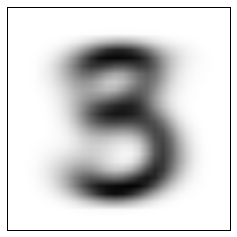

In [17]:
print "This cluster center is most often assoicated with the label " + str(mappingDic[3])
printClusters([3])

This cluster center is most often assoicated with the label 6


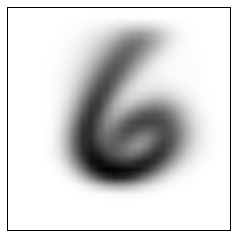

In [18]:
print "This cluster center is most often assoicated with the label " + str(mappingDic[4])
printClusters([4])

This cluster center is most often assoicated with the label 1


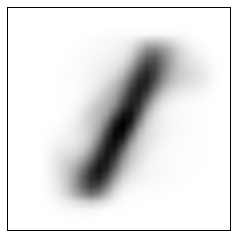

In [19]:
print "This cluster center is most often assoicated with the label " + str(mappingDic[5])
printClusters([5])

This cluster center is most often assoicated with the label 0


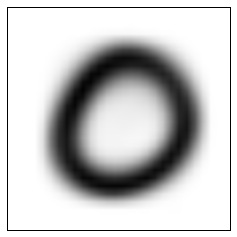

In [20]:
print "This cluster center is most often assoicated with the label " + str(mappingDic[6])
printClusters([6])

This cluster center is most often assoicated with the label 0


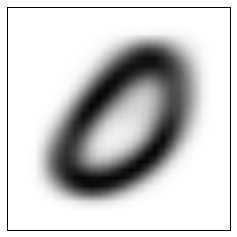

In [21]:
print "This cluster center is most often assoicated with the label " + str(mappingDic[7])
printClusters([7])

This cluster center is most often assoicated with the label 4


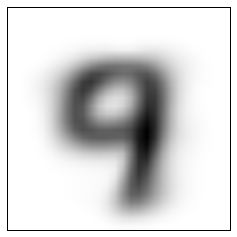

In [22]:
print "This cluster center is most often assoicated with the label " + str(mappingDic[8])
printClusters([8])

This cluster center is most often assoicated with the label 1


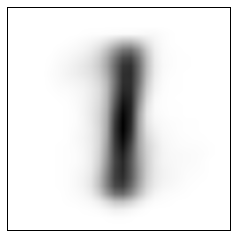

In [23]:
print "This cluster center is most often assoicated with the label " + str(mappingDic[9])
printClusters([9])

##### Remarks 

I ran the code above several times to get a feel for the types of results that it generally produced. I found that the label "5" was the most difficult to capture. Very often, two cluster centers would map to the label "1". One of the cluster centers would be a clear vertical line. The other would be diagonal line that could have represented a "5". The other consistent error in the clusterings was the confusion of the labels "4", "7", and "9". Since there is a lot of variability in how people draw each of these digits, it makes sense that they are difficult to capture. For example, a "4" with the top closed looks very similar to a nine.

##### Cross Validation 

Here, I implement the above functions and two below to test various levels of k for the KMeans clustering algorithm with cross validation. I use the training data to get the cluster centers and the mappings of cluster center to digit label. I predict each picture in the testing set to a cluster center. Then, using the mapping dictionary, I determine if that was an accurate prediction.

I use the first method instead of the second method to get the mappings because it is faster.

In [24]:
def isPredError(x):
    if x[0] == x[1]:
        return 0
    else:
        return 1

In [25]:
def getTestError(testData, clusters, mappingDic):
    testPreds = testData.map(lambda x: (clusters.predict(x[1]), x[0]))
    predsMapped = testPreds.map(lambda x: (mappingDic[x[0]], x[1]))
    numErrors = predsMapped.map(isPredError).reduce(lambda x,y: x+y)
    return float(numErrors) / testData.count()

In [29]:
# I reduced the number of iterations and runs to make it go faster
errors = []
for k in range(3, 30, 3):
    clusters = KMeans.train(trainPixels, k, maxIterations=20, runs=3, initializationMode="random")
    mappings = getClusterMappings(trainData, clusters)
    mappingDic = createMappingDic(mappings, k)
    error = getTestError(testData, clusters, mappingDic)
    errors.append(error)

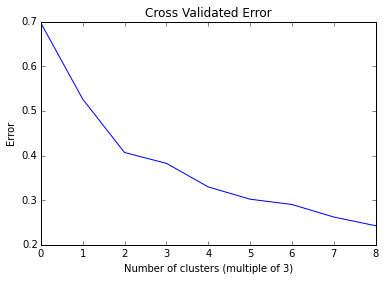

In [31]:
plt.plot(errors)
plt.title("Cross Validated Error")
plt.xlabel("Number of clusters (multiple of 3)")
plt.ylabel("Error")
plt.show()

##### Interpretation 

Since there is so little noise in the MNIST data, the error rate does not increase when we cross-validate on the test data. The MNIST data is so standardized that increasing the number of clusters will reduce the error rate.

##### Optional 

Below, I implement KMeans as a supervised classifier. I changed the number of iterations and runs for KMeans, so that the computation would not take as long. The first thing that I did was generate a clusters for each subset of the data (where the subset come from the images). I put all of these clusters in a big list. Then I looped through each image in the testing data and classified the image based on which centroid it was closest to.

In [42]:
def getTenClusters(trainData, k):
    bigClusterList = []
    for i in range(10):
        subsetI = trainData.filter(lambda x: x[0] == i)
        subsetPixels = subsetI.map(lambda x: x[1])
        clusters = KMeans.train(subsetPixels, k, maxIterations=25, runs=5, initializationMode="random")
        centroids = clusters.centers
        bigClusterList.append(centroids)
    return bigClusterList

In [49]:
def findClosest(image, bigClusterList):
    bestDistance = float("inf")
    bestLabel = -1
    for i in range(len(bigClusterList)):
        for j in range(len(bigClusterList[0])):
            distance = np.linalg.norm(image - bigClusterList[i][j])
            if distance < bestDistance:
                bestDistance = distance
                bestLabel = i
    return bestLabel

In [50]:
def isError(x):
    if x[0] == x[1]:
        return 0
    else:
        return 1

In [51]:
def getTestError(testData, bigClusterList):
    classified = testData.map(lambda x: (x[0], findClosest(x[1], bigClusterList)))
    numErrors = classified.map(isError).sum()
    return float(numErrors) / testData.count()

In [54]:
errors = []
for numClusters in range(2, 10):
    bigClusterList = getTenClusters(trainData, numClusters)
    error = getTestError(testData, bigClusterList)
    errors.append(error)

In [55]:
errors

[0.14153085760085493,
 0.12196099385519636,
 0.10646540208388992,
 0.09744857066524179,
 0.08983435746727224,
 0.08896606999732834,
 0.08589366818060379,
 0.08101790008014961]

These error rates are pretty good. It makes sense that they are monotonically increasing in the number of clusters